# Project Introduction
In this project, we are going to investigate the fraud case of the Enron, which is one the largest companies in the United States in 2000, and which by 2002 had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information availabe to the public, including tens of thousands of emails and detailed financial data for top executives. 
For this project, we are going to try to indentify the "person of interest" (poi) from the people (146 people total) involved by using the machine learning technique. In the Enron dataset, 21 features (with 'poi' as one feature) are provided and other information such as the emails of each individual people are provided.   

In [66]:
%matplotlib inline
import sys
import pickle
from pandas import DataFrame
import matplotlib.pyplot as plt
import pandas as np
import tester
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit, email_parser
from tester import dump_classifier_and_data
from plot_functions import *

# functions to put new features into my_dataset
def insert_new_feature(my_dataset, new_feature, df):
    for name in my_dataset.keys():
        if name in name_list:
            for feature in new_feature:
                my_dataset[name][feature] = float(df[feature][df.name == name])
        else:
            for feature in new_feature:    
                my_dataset[name][feature] = 'NaN'
    return my_dataset
    
### return the selected features
def select_features(features, selects):
    features_selected =['poi']
    for i, select in enumerate(selects):
        if select:
            features_selected.append(features[i])
        
    return features_selected


            
            
def test_clf(clf, labels, features, folds = 1000):

    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    c_matrix = [[0,0],[0,0]]
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        
        c_matrix+=confusion_matrix(labels_test, predictions)
        
    try:
        true_negatives = c_matrix[0][0]
        false_negatives = c_matrix[1][0]
        false_positives = c_matrix[0][1]
        true_positives = c_matrix[1][1]
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
#        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print "accuracy: {}, precison: {}, \n recall: {}, f1: {}".format(accuracy, precision, recall, f1, display_precision = 5)
        print "true positive: {}, false positive: {}, \n false negative: {}, true negative: {}".format(true_positives, false_positives, false_negatives, true_negatives)
#        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."
        
        
def refcv_figure(rfecv):
    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (f1)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

person with all zero data is: LOCKHART EUGENE E
people with all NA value: LOCKHART EUGENE E


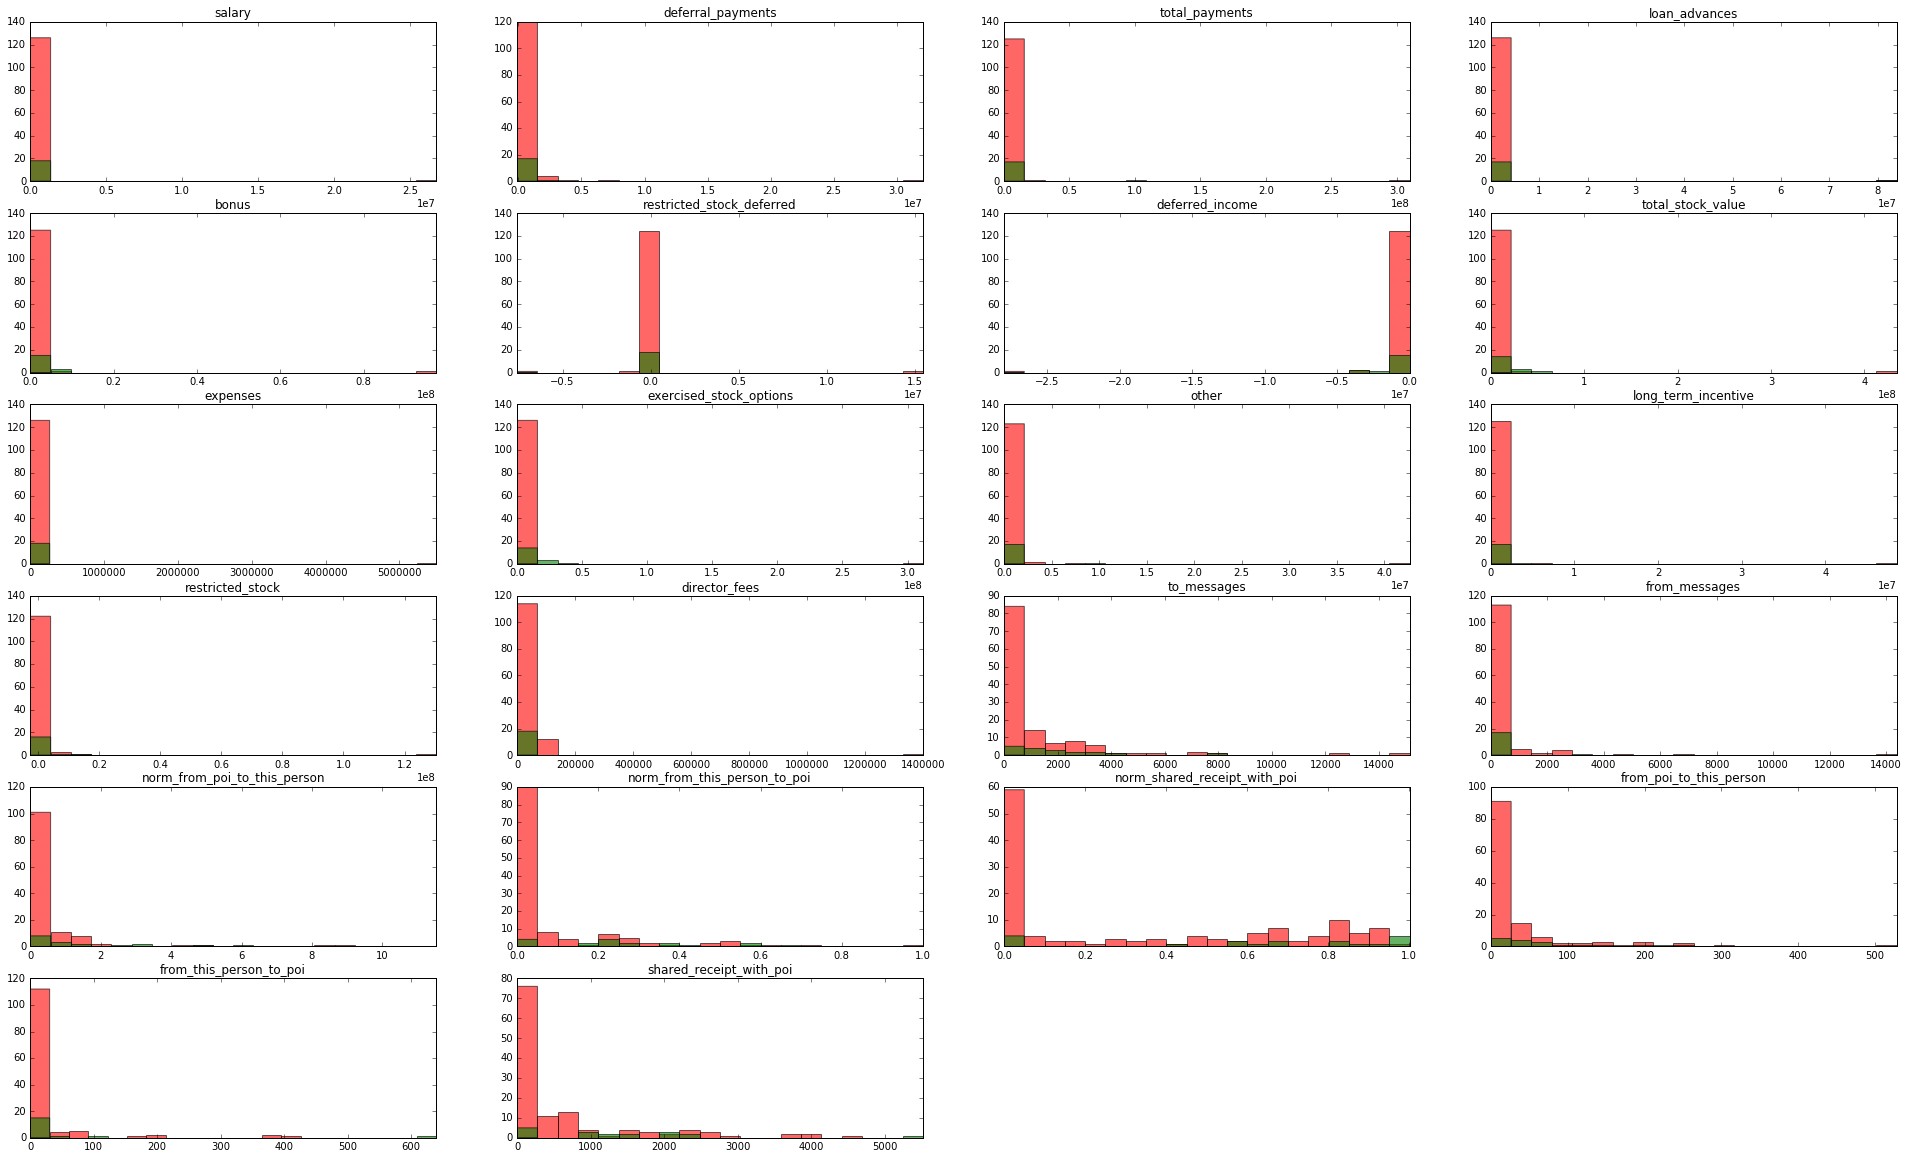

In [67]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
#### use total 20 features out of 21 features, 'email_address' feature not used.
features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', \
'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', \
'total_stock_value', 'expenses', 'exercised_stock_options', 'other', \
'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', \
 'from_poi_to_this_person', 'from_messages', \
 'from_this_person_to_poi', 'shared_receipt_with_poi']  # You will need to use more features



    

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = False)
name_list, emails = email_parser(my_dataset)

ind = name_list.index('LOCKHART EUGENE E')
print "people with all NA value: {}".format(name_list.pop(ind))
emails.pop(ind)
labels, features = targetFeatureSplit(data)

# make the data into the Pandas dataframe, easirer for data manipulation.
df = DataFrame(data=features, columns=features_list[1:])
df['poi'] = labels

# make new features
df_describe_bypoi = df.groupby('poi').describe()
df['name'] = name_list
df['email'] = emails
df['norm_from_poi_to_this_person'] = df.apply(lambda row: row['from_poi_to_this_person']/row['from_messages'] if row['from_messages']!=0 else 0 , axis=1)
df['norm_shared_receipt_with_poi'] = df.apply(lambda row: row['shared_receipt_with_poi']/row['to_messages'] if row['to_messages']!=0 else 0, axis = 1)
df['norm_from_this_person_to_poi'] = df.apply(lambda row: row['from_this_person_to_poi']/row['from_messages'] if row['from_messages']!=0 else 0, axis = 1)
new_feature = ['norm_from_poi_to_this_person', 'norm_shared_receipt_with_poi', 'norm_from_this_person_to_poi' ]

# insert new features into my_dataset for tester.py
          
my_dataset =  insert_new_feature(my_dataset, new_feature, df)   

#add the new fueaturess into the feature list

features_list2 = ['poi', 'salary', 'deferral_payments', 'total_payments', \
'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', \
'total_stock_value', 'expenses', 'exercised_stock_options', 'other', \
'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', \
 'from_messages', 'norm_from_poi_to_this_person', 'norm_from_this_person_to_poi', \
 'norm_shared_receipt_with_poi', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']


figure = plt.figure(figsize=(27, 20))
j = 1
for i, feature1 in enumerate(features_list2[1:]):
    

    y_name = features_list2[0]
    key = feature1
    bin_step = 20
    all_data = df[[y_name, key]]    
    # Remove NaN values from Age data
    all_data = all_data[~np.isnan(all_data[key])]        
    # Divide the range of data into bins and count survival rates
    min_value = all_data[key].min()
    max_value = all_data[key].max()
    value_range = max_value - min_value
    bins = np.arange(min_value, max_value +  value_range/bin_step, value_range/bin_step )
    y0 = all_data[all_data[y_name] == 0][key].reset_index(drop = True)
    y1 = all_data[all_data[y_name] == 1][key].reset_index(drop = True)
    ax = plt.subplot(len(features_list2)/4+1,  4, j)
    ax.hist(y0, bins = bins, alpha = 0.6, color = 'red', label = 'y0')
    ax.hist(y1, bins = bins, alpha = 0.6, color = 'green', label = 'y1')
    ax.set_xlim(bins.min(), bins.max())
    ax.set_title(key)
#    ax.legend(framealpha = 0.8)
    j+=1
    
figure.subplots_adjust(left=.02, right=.98)
plt.show()

In [68]:
outlier_name1 =  str(df['name'][df.salary ==df['salary'].max()])
outlier_name2 =  str(df['name'][df.bonus ==df['bonus'].max()])
outlier_name3 =  str(df['name'][df.other ==df['other'].max()])
print outlier_name1, outlier_name2, outlier_name3

df = df[df.salary !=df['salary'].max()]
print my_dataset.pop('TOTAL',0)



103    TOTAL
Name: name, dtype: object 103    TOTAL
Name: name, dtype: object 103    TOTAL
Name: name, dtype: object
{'to_messages': 'NaN', 'deferral_payments': 32083396, 'expenses': 5235198, 'poi': False, 'deferred_income': -27992891, 'email_address': 'NaN', 'long_term_incentive': 48521928, 'norm_from_poi_to_this_person': 0.0, 'restricted_stock_deferred': -7576788, 'norm_from_this_person_to_poi': 0.0, 'shared_receipt_with_poi': 'NaN', 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'director_fees': 1398517, 'norm_shared_receipt_with_poi': 0.0, 'bonus': 97343619, 'total_stock_value': 434509511, 'from_poi_to_this_person': 'NaN', 'from_this_person_to_poi': 'NaN', 'restricted_stock': 130322299, 'salary': 26704229, 'total_payments': 309886585, 'exercised_stock_options': 311764000}


from the figure plots above, it appears both salary, bonus, deferral payments and a lot of features have a clear outlier. By looking into the dataset (not shown here), they all linked to one name called "TOTAL", which appears to be sum of TOTAL of the people, should definitely be excluded from the dataset

And the replotting figure is shown below, there are still couple very large values for couple features, by looking into the details, those are with valid name and will not be filtered out.

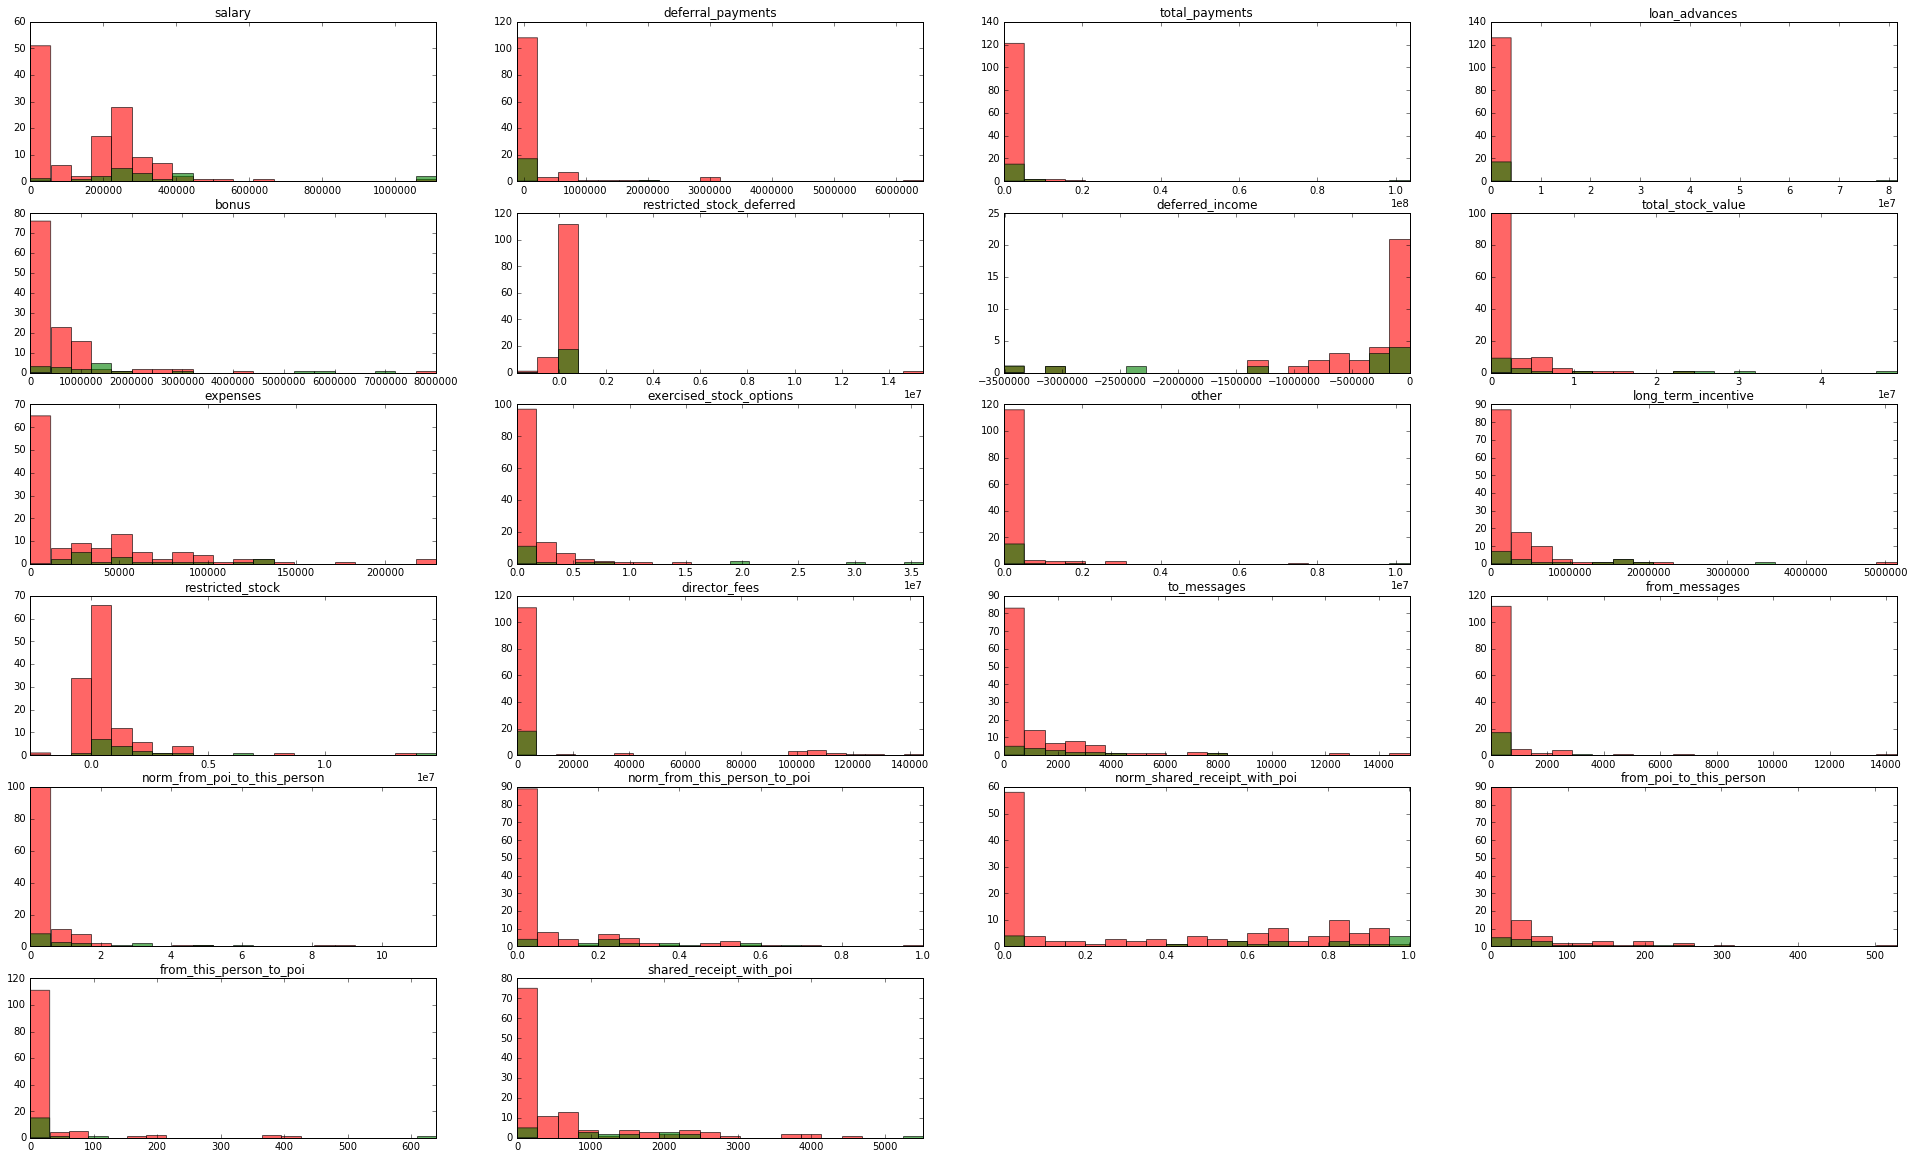

In [69]:
figure = plt.figure(figsize=(27, 20))
j = 1
for i, feature1 in enumerate(features_list2[1:]):
    

    y_name = features_list2[0]
    key = feature1
    bin_step = 20
    all_data = df[[y_name, key]]    
    # Remove NaN values from Age data
    all_data = all_data[~np.isnan(all_data[key])]        
    # Divide the range of data into bins and count survival rates
    min_value = all_data[key].min()
    max_value = all_data[key].max()
    value_range = max_value - min_value
    bins = np.arange(min_value, max_value +  value_range/bin_step, value_range/bin_step )
    y0 = all_data[all_data[y_name] == 0][key].reset_index(drop = True)
    y1 = all_data[all_data[y_name] == 1][key].reset_index(drop = True)
    ax = plt.subplot(len(features_list2)/4+1,  4, j)
    ax.hist(y0, bins = bins, alpha = 0.6, color = 'red', label = 'y0')
    ax.hist(y1, bins = bins, alpha = 0.6, color = 'green', label = 'y1')
    ax.set_xlim(bins.min(), bins.max())
    ax.set_title(key)
#    ax.legend(framealpha = 0.8)
    j+=1
    
figure.subplots_adjust(left=.02, right=.98)
plt.show()

In [50]:
outlier_name1 =  str(df['name'][df.loan_advances ==df['loan_advances'].max()])
outlier_name2 =  str(df['name'][df.bonus ==df['bonus'].max()])
outlier_name3 =  str(df['name'][df.other ==df['other'].max()])
print outlier_name1, outlier_name2, outlier_name3

65    LAY KENNETH L
Name: name, dtype: object 43    LAVORATO JOHN J
Name: name, dtype: object 65    LAY KENNETH L
Name: name, dtype: object


Starting below we will try a variety of classifiers, and for feature selections, I will try using the automatic selection method RFECV method: Feature ranking with recursive feature elimination and cross-validated selection of the best number of feature.

http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [70]:
### Task 4: Try a variety of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

features =df[features_list2[1:]]
features = features.fillna(features.mean())
for name in df.name:
    if name in my_dataset.keys():
        for columns in features.columns:
            my_dataset[name][columns] = float(df[columns][df.name == name])
labels =df[features_list2[0]]
labels = np.array(labels)
features = np.array(features)

Optimal number of features : 8


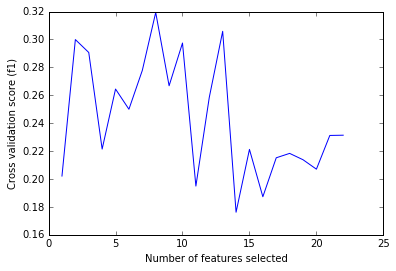

LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=14,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
accuracy: 0.506933333333, precison: 0.187006960557, 
 recall: 0.806, f1: 0.303578154426
true positive: 1612, false positive: 7008, 
 false negative: 388, true negative: 5992

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=14,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=14,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
accuracy: 0.79706666

In [71]:
### RFECV method and try 4 different classifier method: logistic regression, Decision Tree, Random Forrest and Adaptive boosting 


clf_Log = LogisticRegression(random_state = 14, C= 5, class_weight='balanced')
selectorCV_Log = RFECV(clf_Log, step=1, cv=5, scoring = 'f1')
selectorCV_Log.fit(features, labels)
refcv_figure(selectorCV_Log)
clf = selectorCV_Log.estimator_
features_new = selectorCV_Log.transform(features)
test_clf(clf, labels, features_new, folds = 1000)

param_grid = {"C": [0.01, 0.1, 1, 5, 10, 100, 1000],
              "penalty" : ['l1', 'l2']
        }

clf_Log_searchCV = GridSearchCV(clf, param_grid, scoring ='f1', cv=10)
clf_Log_searchCV.fit(features, labels)
print clf_Log_searchCV.best_estimator_
test_clf(clf_Log_searchCV.best_estimator_, labels, features_new, folds = 1000)





Optimal number of features : 5


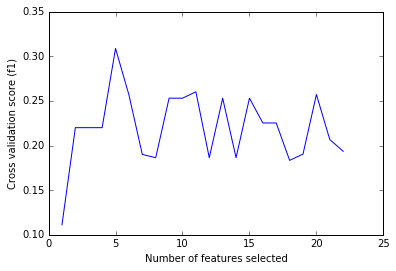

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=32,
            splitter='best')
accuracy: 0.8504, precison: 0.440776699029, 
 recall: 0.454, f1: 0.447290640394
true positive: 908, false positive: 1152, 
 false negative: 1092, true negative: 11848

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=5, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=32, splitter='best') DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=5, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=1, min_weight_fraction_leaf=0.0,
            presort=False, random_state=32, splitter='bes

In [72]:
### 
clf_DT = DecisionTreeClassifier(random_state= 32, class_weight='balanced')
selectorCV_DT = RFECV(clf_DT, step=1, cv=5, scoring = 'f1')
selectorCV_DT.fit(features, labels)
refcv_figure(selectorCV_DT)
clf = selectorCV_DT.estimator_
features_new = selectorCV_DT.transform(features)
test_clf(clf, labels, features_new, folds = 1000)
#parameters={'min_samples_split' : range(2,20,2),'max_depth': range(1,10,2), 'criterion': ['gini', 'entropy']}
param_grid = {"max_depth": [1,4,7, None],
              "max_features": [1, 3, 5, 7],
              "min_samples_split": [1, 2, 4, 7],
              "min_samples_leaf": [1, 3, 10],
              "criterion": ["gini", "entropy"]}
clf_DT_searchCV = GridSearchCV(clf, param_grid, scoring ='f1', cv=10)
clf_DT_searchCV.fit(features, labels)
print clf_DT_searchCV.best_estimator_,
test_clf(clf_DT_searchCV.best_estimator_, labels, features_new, folds = 1000)




Optimal number of features : 6


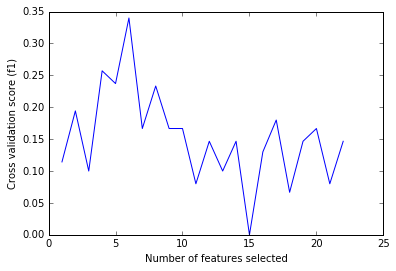

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False)
accuracy: 0.8626, precison: 0.451816745656, 
 recall: 0.143, f1: 0.217242688948
true positive: 286, false positive: 347, 
 false negative: 1714, true negative: 12653

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False) RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
   

In [73]:
clf_rf =   RandomForestClassifier(n_estimators=20, max_features='auto', class_weight='balanced', random_state=24)
selectorCV_rf = RFECV(clf_rf, step=1, cv=5, scoring = 'f1')
selectorCV_rf.fit(features, labels)
refcv_figure(selectorCV_rf)
clf = selectorCV_rf.estimator_
features_new = selectorCV_rf.transform(features)
test_clf(clf, labels, features_new, folds = 1000)
param_grid = {
    "n_estimators": range(20,50,300),
    "max_features": ['auto', 'sqrt', 'log2'],
    "min_samples_split": [1, 2, 4, 7],
    "min_samples_leaf": [1, 3, 10],
    "criterion": ["gini", "entropy"]}    
clf_rf_searchCV = GridSearchCV(clf, param_grid, scoring = 'f1', cv = 10)
clf_rf_searchCV.fit(features, labels)
print clf_rf_searchCV.best_estimator_,
test_clf(clf_rf_searchCV.best_estimator_, labels, features_new, folds = 1000)



Optimal number of features : 7


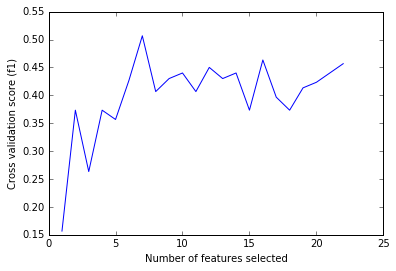

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=25)
accuracy: 0.866666666667, precison: 0.5, 
 recall: 0.5165, f1: 0.508116084604
true positive: 1033, false positive: 1033, 
 false negative: 967, true negative: 11967

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best'),
          learning_rate=0.1, n_estimators=20, random_state=25

In [74]:
DTC = DecisionTreeClassifier(random_state = 11, class_weight = "balanced")
clf_AdaB =  AdaBoostClassifier(base_estimator = DTC, n_estimators=50, learning_rate=1.0, random_state=25)
selectorCV_AdaB = RFECV(clf_AdaB, step=1, cv=10, scoring = 'f1')
selectorCV_AdaB.fit(features, labels)
refcv_figure(selectorCV_AdaB)
clf = selectorCV_AdaB.estimator_
features_new = selectorCV_AdaB.transform(features)
test_clf(clf, labels, features_new, folds = 1000)
param_grid = {
    "n_estimators": range(20,50,300),
    "learning_rate": [0.1, 1, 10, 100],
    "algorithm": ['SAMME', 'SAMME.R']}    
clf_AdaB_searchCV = GridSearchCV(clf, param_grid, scoring = 'f1', cv=10)
clf_AdaB_searchCV.fit(features, labels)
print clf_AdaB_searchCV.best_estimator_,
test_clf(clf_AdaB_searchCV.best_estimator_, labels, features_new, folds = 1000)

## Summary of the 4 models:

Classifier | Features used|  Accuracy | Precision  | Recall   | F1 score |
--- | --- | --- | --- | --- | --- | --- 
*Logisitc* |8 | 0.797 | 0.354 | 0.634 |0.454
*Decision Tree* | 5 | 0.775 | 0.340 | 0.732 |0.464
*Random Forrest* | 6 | 0.817 | 0.385 | 0.619 |0.474 
*Ada boosting* | 7 | 0.867 | 0.5 | 0.517 |0.508 


In [75]:
clf = clf_Log_searchCV.best_estimator_

features_selected = select_features(features_list2[1:], selectorCV_Log.support_)
print 'CV_Log:'
print features_selected
dump_classifier_and_data(clf, my_dataset, features_selected)
tester.main()
   
clf = clf_DT_searchCV.best_estimator_
features_selected = select_features(features_list2[1:], selectorCV_DT.support_)
print 'CV_DT:'
print features_selected
dump_classifier_and_data(clf, my_dataset, features_selected)
tester.main()


clf = selectorCV_rf.estimator_
clf = clf_rf_searchCV.best_estimator_
features_selected = select_features(features_list2[1:], selectorCV_rf.support_)
print 'CV_rf:'
print features_selected
dump_classifier_and_data(clf, my_dataset, features_selected)
tester.main()


clf = selectorCV_AdaB.estimator_
clf = clf_AdaB_searchCV.best_estimator_
features_selected = select_features(features_list2[1:], selectorCV_AdaB.support_)
print 'CV_AdaB:'
print features_selected
dump_classifier_and_data(clf, my_dataset, features_selected)
tester.main()









CV_Log:
['poi', 'total_stock_value', 'exercised_stock_options', 'restricted_stock', 'director_fees', 'to_messages', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
person with all zero data is: GRAY RODNEY
person with all zero data is: LOCKHART EUGENE E
person with all zero data is: THE TRAVEL AGENCY IN THE PARK
person with all zero data is: WODRASKA JOHN
LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=14,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
	Accuracy: 0.79520	Precision: 0.35498	Recall: 0.65600	F1: 0.46067	F2: 0.56088
	Total predictions: 15000	True positives: 1312	False positives: 2384	False negatives:  688	True negatives: 10616

CV_DT:
['poi', 'total_stock_value', 'expenses', 'other', 'norm_from_this_person_to_poi', 'from_poi_to_this_person']
person with all zero data is: CHAN RONNIE
